<a href="https://colab.research.google.com/github/miquelmassot/detectron2_heatmaps/blob/main/Detectron2_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-wujuypzw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-wujuypzw
  Resolved https://github.com/facebookresearch/detectron2.git to commit 1523b3e9929a06d798871eb9afc4c9f770743baf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import cv2
import os
import json
import numpy as np
from pathlib import Path
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from google.colab.patches import cv2_imshow

In [10]:
def get_balloon_dicts(img_dir='oplab_dataset'):
    dataset_dicts = []

    # Find all images in the folder
    img_path = Path(img_dir)
    idx = 0
    for img in img_path.glob("*.jpg"):
        if "mask" in img.stem:
            continue
        print("Found image: ", img.stem)
        mask_img = img_path / (img.stem + "_mask.jpg")

        record = {}
        height, width = cv2.imread(str(img)).shape[:2]
        mask = cv2.imread(str(mask_img))
        record["file_name"] = str(img)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        obj = {
            "bbox": [0, 0, width, height],
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": [mask],
            "category_id": 0,
        }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        idx += 1
    return dataset_dicts

DatasetCatalog.clear()
DatasetCatalog.register("oplab_dataset", get_balloon_dicts)
MetadataCatalog.get("oplab_dataset").set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("oplab_dataset")

dataset_dicts = get_balloon_dicts("oplab_dataset")

Found image:  A
Found image:  B


In [11]:
print(dataset_dicts)

[{'file_name': 'oplab_dataset/A.jpg', 'image_id': 0, 'height': 768, 'width': 1024, 'annotations': [{'bbox': [0, 0, 1024, 768], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [

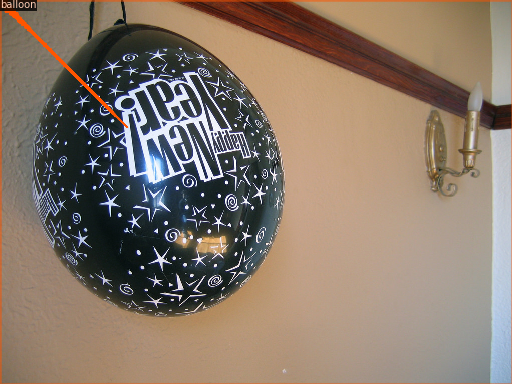

In [13]:
d = dataset_dicts[0]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("oplab_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/13 15:39:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:12, 14.5MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[02/13 15:39:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/13 15:40:38 d2.utils.events]:  eta: 0:13:34  iter: 19  total_loss: 1.673  loss_cls: 0.6391  loss_box_reg: 0.2532  loss_mask: 0.6763  loss_rpn_cls: 0.01726  loss_rpn_loc: 0.1039  time: 2.8997  data_time: 0.1114  lr: 1.6068e-05  max_mem: 2546M
[02/13 15:41:35 d2.utils.events]:  eta: 0:12:17  iter: 39  total_loss: 1.218  loss_cls: 0.372  loss_box_reg: 0.2559  loss_mask: 0.4808  loss_rpn_cls: 0.01669  loss_rpn_loc: 0.09599  time: 2.8701  data_time: 0.0881  lr: 3.2718e-05  max_mem: 2546M
[02/13 15:42:32 d2.utils.events]:  eta: 0:11:18  iter: 59  total_loss: 0.7599  loss_cls: 0.2056  loss_box_reg: 0.2369  loss_mask: 0.2372  loss_rpn_cls: 0.006061  loss_rpn_loc: 0.06099  time: 2.8584  data_time: 0.0862  lr: 4.9367e-05  max_mem: 2546M
[02/13 15:43:28 d2.utils.events]:  eta: 0:10:22  iter: 79  total_loss: 0.5638  loss_cls: 0.16  loss_box_reg: 0.2417  loss_mask: 0.1142  loss_rpn_cls: 0.003612  loss_rpn_loc: 0.04007  time: 2.8520  data_time: 0.0819  lr: 6.6017e-05  max_mem: 2546M
[02/13 15:44